In [1]:
import os
from concurrent.futures import ProcessPoolExecutor
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, BatchNormalization
from tensorflow.keras import utils, Sequential

from utils import err
from repository.insurance_premium_estimation_repository import (generate_random_insurance_data,
                                                                LockType, FrameMaterial, BikeType, WK_DEVICE_VERSIONS,
                                                                MIN_PRICE, MAX_PRICE, MIN_LOCK_PRICE, MAX_LOCK_PRICE, MAX_SECONDS_IN_MONTH)
from services.insurance_premium_estimation_service import prepare_insurance_data as prepare_data
from services.insurance_premium_estimation_service import _simple_insurance_premium_prediction

SAVES_PATH_RELATIVE = 'checkpoints/'
SAVES_PATH = os.path.join(os.path.dirname(SAVES_PATH_RELATIVE), SAVES_PATH_RELATIVE)
BATCH_SIZE = 64
DATA_COUNT = 50000


# tf.config.experimental.set_virtual_device_configuration(
#     tf.config.experimental.list_physical_devices('GPU')[0],
#     [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10240)]
# )

def generate_dataset(size: int) -> tuple[np.array, np.array]:
    return tuple(zip(*(
        (i.as_list_of_values(), _simple_insurance_premium_prediction(i)) for i in (generate_random_insurance_data() for _ in range(size))
    )))


In [2]:
data_x, data_y = generate_dataset(DATA_COUNT)

print(data_x[:5])
print(data_y[:5])

([3806.01, 3, 1, 2, 988450, 0.0, 0.0, 0.1522433772063736, 0.2214033207532215, 0.0, 32874, 38.64, 2, True, False], [1966.34, 2, 8, 1, 1210805, 0.025372831013792778, 0.0, 0.6131223617825283, 0.4698656367095586, 0.04099421882552903, 40449, 29.94, 2, False, False], [4763.02, 3, 9, 0, 803928, 0.0, 0.0824381166594577, 0.524669855720088, 0.5269758967822152, 0.0, 26697, 17.78, 3, True, True], [4353.05, 2, 2, 2, 1407357, 0.0, 0.005400005493594461, 0.05777017780594185, 0.15285884893805712, 0.0, 46744, 15.36, 2, True, False], [995.03, 2, 4, 1, 1263733, 0.06605960014391686, 0.20643400436458814, 0.1406500557934805, 0.08386255081530711, 0.059801313758434595, 42409, 22.56, 2, False, True])
(18.12, 13.61, 17.76, 54.97, 42.3)


In [3]:
data_x_prepared, data_y_prepared = prepare_data(data_x, data_y)
x_size = len(data_x_prepared[0])

print(data_x_prepared[:5])
print(data_y_prepared[:5])
print()
print(data_x_prepared.shape)
print(data_y_prepared.shape)

[[0.37434444 0.         0.         0.         1.         0.
  1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  1.         0.         0.         0.         0.36904495 0.
  0.         0.15224338 0.22140332 0.         0.01227375 0.03574724
  1.         0.         1.         0.        ]
 [0.18851919 0.         0.         1.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         1.         0.         0.         0.         1.
  0.         0.         0.         0.         0.4520628  0.02537283
  0.         0.61312236 0.46986564 0.04099422 0.01510193 0.02702106
  1.         0.         0.         0.        ]
 [0.47101212 0.         0.         0.         1.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         1.         0.         0.         0.
  0.         0.         0.         1.         0.30015233 0.
  0.08243812 0.52466986 0.5269759  0.     

In [8]:
# def get_inner():
#     x = Input((x_size * 8, ))
#     x_in = x
#     x = Dense(x_size * 16, activation="leaky_relu")(x)
#     tf.keras.layers.Dropout(0.1),
#     x = Dense(x_size * 8, activation="leaky_relu")(x)
#     y = Dense(x_size * 8, activation="leaky_relu")(x_in)
#     y = tf.keras.layers.Add()([x, y])
#     y = tf.keras.activations.relu(y)
#     return tf.keras.models.Model(inputs = x_in, outputs = y)

# inner_model1 = get_inner()

# model = Sequential([
#     Input((x_size, )),
#     Dense(x_size * 16, activation="leaky_relu"),
#     tf.keras.layers.Dropout(0.1),
#     Dense(x_size * 8, activation="leaky_relu"),
#     inner_model1,
#     Dense(x_size * 8, activation="leaky_relu"),
#     get_inner(),
#     tf.keras.layers.Dropout(0.1),
#     Dense(x_size * 4, activation="leaky_relu"),
#     Dense(1, activation="leaky_relu")
# ])
model = Sequential([
    Input((x_size, )),
    Dense(x_size * 4, activation="leaky_relu"),
    Dense(x_size * 8, activation="leaky_relu"),
    Dense(x_size * 16, activation="leaky_relu"),
    tf.keras.layers.Dropout(0.1),
    Dense(x_size * 8, activation="leaky_relu"),
    Dense(x_size * 4, activation="leaky_relu"),
    Dense(1, activation="leaky_relu")
])

model.compile(
    tf.keras.optimizers.Adam(learning_rate=0.0011),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[err]
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 136)               4760      
                                                                 
 dense_7 (Dense)             (None, 272)               37264     
                                                                 
 dense_8 (Dense)             (None, 544)               148512    
                                                                 
 dropout_1 (Dropout)         (None, 544)               0         
                                                                 
 dense_9 (Dense)             (None, 272)               148240    
                                                                 
 dense_10 (Dense)            (None, 136)               37128     
                                                                 
 dense_11 (Dense)            (None, 1)                

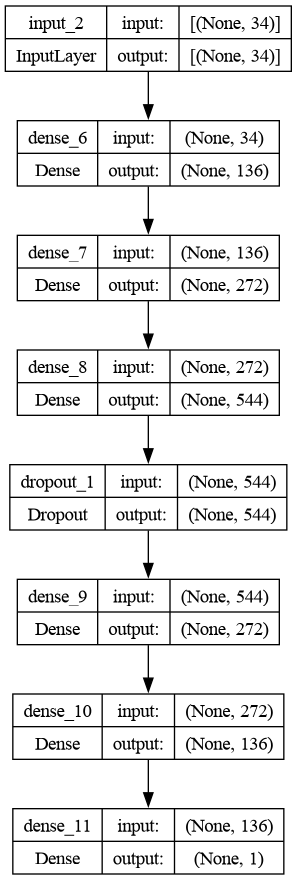

In [9]:
model.summary()
utils.plot_model(model, show_shapes=True)

In [10]:
# inner_model1.summary()
# utils.plot_model(inner_model1, show_shapes=True)

In [11]:
history = model.fit(
    data_x_prepared,
    data_y_prepared,
    epochs=128,
    batch_size=BATCH_SIZE,
    shuffle=True,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            SAVES_PATH + "checkpoint-{epoch:02d}-{val_loss:.4f}.hdf5",
            monitor='val_loss',
            save_weights_only=True
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_err', min_delta=0.0001, patience=20, verbose=1
        )
    ],
    verbose=True,
    validation_split=0.2
)
model.save_weights(SAVES_PATH + "result.hdf5")

Epoch 1/128
625/625 [==============================] - 3s 4ms/step - loss: 55.6323 - err: 3.8430 - val_loss: 14.5188 - val_err: 1.9337
Epoch 2/128
625/625 [==============================] - 3s 4ms/step - loss: 14.8434 - err: 2.1198 - val_loss: 8.3235 - val_err: 1.3776
Epoch 3/128
625/625 [==============================] - 3s 4ms/step - loss: 10.3950 - err: 1.7488 - val_loss: 7.8265 - val_err: 1.3715
Epoch 4/128
625/625 [==============================] - 3s 4ms/step - loss: 8.2261 - err: 1.5348 - val_loss: 5.8403 - val_err: 1.1484
Epoch 5/128
625/625 [==============================] - 3s 4ms/step - loss: 7.4300 - err: 1.4525 - val_loss: 5.2915 - val_err: 1.3112
Epoch 6/128
625/625 [==============================] - 2s 4ms/step - loss: 7.5196 - err: 1.4933 - val_loss: 6.2422 - val_err: 1.2956
Epoch 7/128
625/625 [==============================] - 2s 4ms/step - loss: 6.4313 - err: 1.3406 - val_loss: 4.8727 - val_err: 1.0739
Epoch 8/128
625/625 [==============================] - 2s 4ms/ste

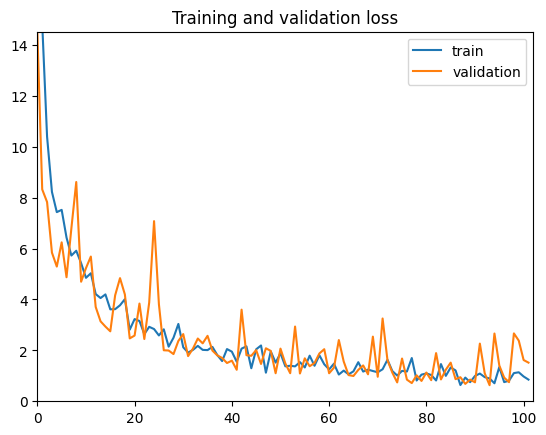

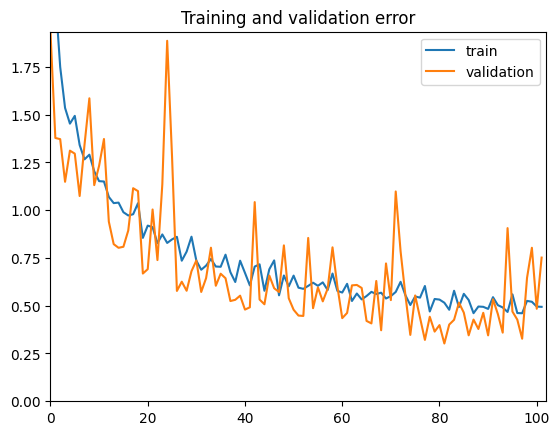

In [12]:
from matplotlib import pyplot as plt

loss = history.history['loss']
plt.figure()
plt.axis((0, len(loss), 0.0, max(history.history['val_loss'])))
plt.plot(range(len(loss)), history.history['loss'], label="train")
plt.plot(range(len(loss)), history.history['val_loss'], label="validation")
plt.title('Training and validation loss')
plt.legend()

err = history.history['err']
plt.figure()
plt.axis((0, len(err), 0.0, max(history.history['val_err'])))
plt.plot(range(len(err)), history.history['err'], label="train")
plt.plot(range(len(err)), history.history['val_err'], label="validation")
plt.title('Training and validation error')
plt.legend()


In [21]:
import json

raw_test_x, raw_test_y = generate_dataset(10)
test_x, test_y = prepare_data(raw_test_x, raw_test_y)

# model.load_weights(SAVES_PATH + "result.hdf5")
# print("Test data:\n" + json.dumps(raw_test_x, indent=4), '\n')
# print()
# print("Correct values: ", test_y, '\n')
# pred = [max(0.0, round(i[0], 2)) for i in model.predict(test_x)]
# print("Predicted values: ", pred, '\n')
# print("Error: ", round(np.average(np.abs(pred - test_y)), 2))
# print()

model.load_weights(SAVES_PATH + "checkpoint-94-0.6319.hdf5")
# model = tf.keras.models.load_model('result-0.4537.keras', custom_objects={'err': err})
print()
print("Correct values: ", test_y, '\n')
pred = [max(0.0, round(i[0], 2)) for i in model.predict(test_x)]
print("Predicted values: ", pred, '\n')
print("Error: ", round(np.average(np.abs(pred - test_y)), 2))
print()


Correct values:  [ 9.4   0.    0.   19.31 12.78 11.44  0.   28.18  0.   17.68] 

1/1 [==============================] - 0s 17ms/step
Predicted values:  [9.03, 0.0, 0.0, 19.25, 12.82, 11.14, 0.0, 28.19, 0.0, 17.46] 

Error:  0.1



In [20]:
model.save("result-0.6319_on50k.keras")